# Carry out a test that varies the length of the forecast window.
How much better or worse is the forecast when the window length grows?

In [1]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Read the data
df = pd.read_csv('jakobshavn.csv', na_values=[-1])

# Ensure df['Date'] is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Initialize the pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Define the range of alphas and n_timeseries to iterate over
alphas = np.arange(0.01, 0.11, 0.01)
n_timeseries_steps = [1] + list(range(10, 101, 10))

# Initialize a 2D NumPy array to store the MAE values
mae_array = np.zeros((len(n_timeseries_steps), len(alphas)))

# Iterate over each value of n_timeseries
for i, n_timeseries in tqdm(enumerate(n_timeseries_steps)):
    # Select the first n_timeseries columns for forecasting
    columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

    # Iterate over each value of alpha
    for j, alpha in enumerate(alphas):
        # Calculate the split index for training
        split_index = int(len(df) * (1 - alpha))

        # Split the data into training and evaluation sets for all selected columns
        train_data = df[columns_to_forecast].iloc[:split_index]
        eval_data = df[columns_to_forecast].iloc[split_index:]

        # Convert the training data to a higher-dimensional tensor
        train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T

        # Perform the forecasting using the training data
        forecast = pipeline.predict(
            context=train_tensor,
            prediction_length=len(eval_data),  # Predict the same length as the evaluation set
            num_samples=50,
        )

        # Calculate the Mean Absolute Error (MAE) for each time series
        mae = np.abs(forecast.mean(axis=1).T - eval_data.values).mean(axis=1).mean()

        # Store the MAE in the 2D array
        mae_array[i, j] = mae



100%|██████████| 10/10 [01:50<00:00, 11.01s/it]


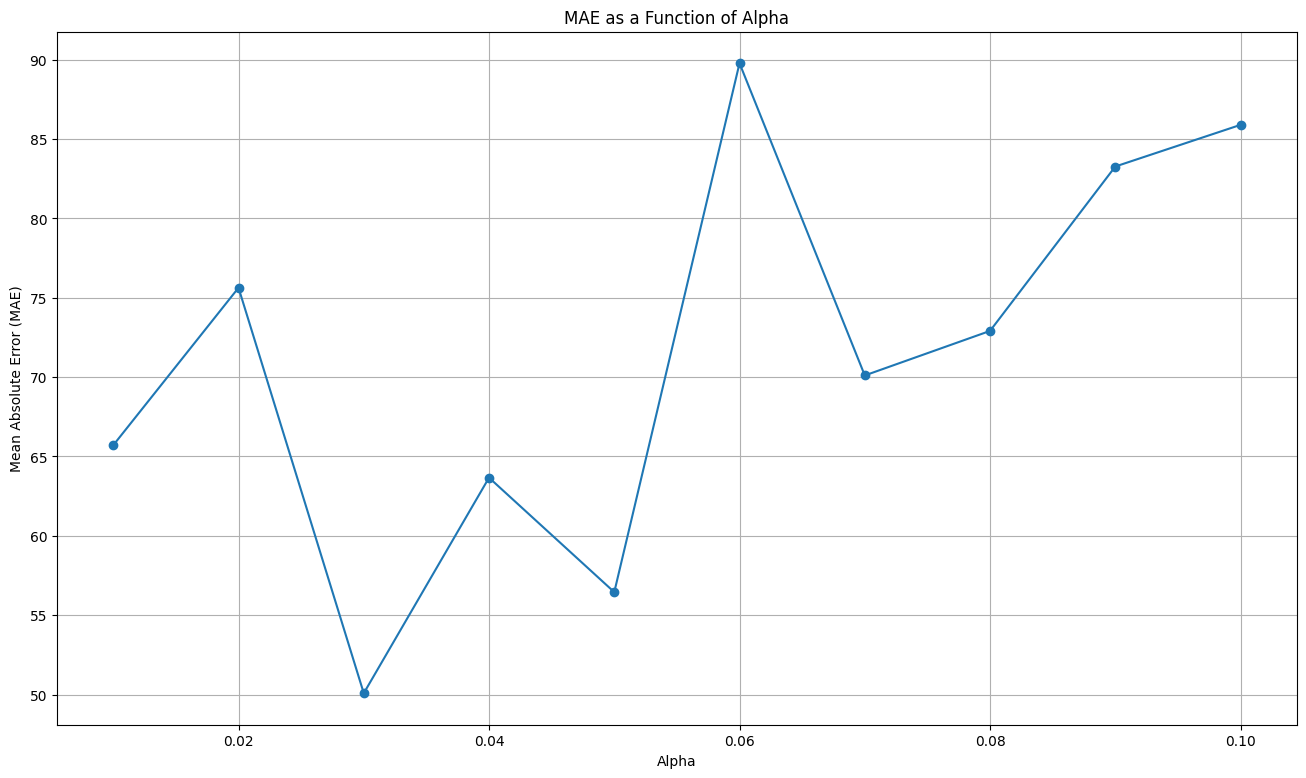

In [2]:
# Plot the MAE as a function of alpha for different n_timeseries
plt.figure(figsize=(12, 8))
for i, n_timeseries in enumerate(n_timeseries_steps):
    plt.plot(alphas, mae_array[i, :], marker='o', label=f'n_timeseries={n_timeseries}')

plt.title('MAE as a Function of Alpha for Different n_timeseries')
plt.xlabel('Alpha')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(title='Number of Time Series')
plt.grid(True)
plt.show()

# # Plot the MAE as a function of alpha
# plt.figure(figsize=(16, 9))
# plt.plot(alphas, mae_list, marker='o')
# plt.title('MAE as a Function of Alpha')
# plt.xlabel('Alpha')
# plt.ylabel('Mean Absolute Error (MAE)')
# plt.grid(True)
# plt.show()